<a href="https://colab.research.google.com/github/baussel/Satellite_Detection/blob/main/Mask_R_CNN_Satellites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Ben Aussel, ESA, August 2021*

Script for the data preparation, creating, training and predictions for the satellite trails in Hubble images with the Mask-RCNN Network. The network backbone is a Resnet101 and Feature Pyramid Networks for Object Detection.

Sources: https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb

https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46

https://arxiv.org/abs/1703.06870

https://arxiv.org/abs/1612.03144

# Code/Modules/Model Preparation

## Installation / Change versions

In [ ]:
#Install the Mask-RCNN module
!pip install mrcnn==0.2
#Weights and Biases - For logging the training runs
!pip install wandb 

In [ ]:
#Adjust the different version that are compatible to each other
#NO CHANGES HERE
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

!pip install tensorflow-gpu==1.13.1
!pip install keras==2.2.5
!pip install h5py==2.10.0

Found existing installation: Keras 2.2.5
Uninstalling Keras-2.2.5:
  Successfully uninstalled Keras-2.2.5
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: h5py 2.10.0
Uninstalling h5py-2.10.0:
  Successfully uninstalled h5py-2.10.0
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached h5py-3.3.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.1 MB)
  Using cached Keras-2.2.5-py2.py3-none-any.whl (336 kB)
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.3.0
    Uninstalling h5py-3.3.0:
      Successfully uninstalled h5py-3.3.0


## Import and setup

In [ ]:
#Import Modules
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import json
import skimage
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

#Root directory of the project
ROOT_DIR = os.path.abspath("../../")

#Import Mask-RCNN modules
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

#Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
#Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## GPU

In [ ]:
#Test if GPU is mounted and selected
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#Select GPU
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


# Data Preparation

## Satellite Config and Class

In [ ]:
class SatelliteConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "satellite"

    # GPU config
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + baloon

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

#Set this as the used config
config = SatelliteConfig()

In [ ]:
class SatelliteDataset(utils.Dataset):

    def load_satellite(self, dataset_dir, subset):
        """Load a subset of the satellite dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("satellite", 1, "satellite")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        #Load annotations
        #VGG Image Annotator saves each image in the form:
        #{ 'filename': 'xxx.jpg',
        #  'regions': {
        #      '0': {
        #          'region_attributes': {},
        #          'shape_attributes': {
        #              'all_points_x': [...],
        #              'all_points_y': [...],
        #              'name': 'polygon'}},
        #      ... more regions ...
        #  },
        #  'size': 100202
        #}

        #We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "lines.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        #The VIA tool saves images in the JSON even if they don't have any
        #annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        #Add images
        for a in annotations:
            #Get the x, y coordinaets of points of the polygons that make up
            #the outline of each object instance. There are stores in the
            #shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in [x for x in a['regions']]]

            #load_mask() needs the image size to convert polygons to masks.
            #Unfortunately, VIA doesn't include it in JSON, so we must read
            #the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "satellite",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """

        #Convert polygons to a bitmap mask of shape
        #[height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            #Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        #Return mask, and array of class IDs of each instance. Since we have
        #one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

## Load and prepare Data

In [ ]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#It's important that the image size can be divided by two six times (e.g. 512x512)
data_path = "/content/drive/MyDrive/ESA/Data/satellite_det/raw_images_ano"

#Training dataset
dataset_train = SatelliteDataset()
dataset_train.load_satellite(data_path,"train")
dataset_train.prepare()

#Validation dataset
dataset_val = SatelliteDataset()
dataset_val.load_satellite(data_path,"val")
dataset_val.prepare()

In [ ]:
#Visualization method
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

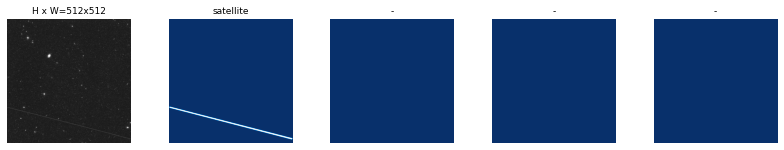

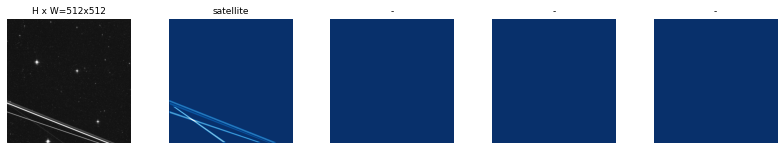

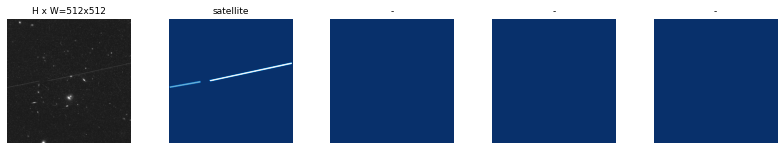

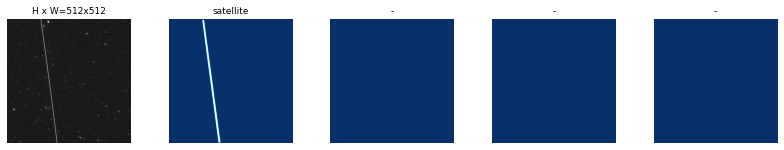

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Training

## Model creation

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training with Dataset

In [ ]:
#Train the head branches
#Passing layers="heads" freezes all layers except the head
#layers. You can also pass a regular expression to select
#which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers="heads")


Starting at epoch 0. LR=0.001

Checkpoint Path: /logs/satellite20210811T1500/mask_rcnn_satellite_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
100/100 [==============================] - 71s 711ms/step - loss: 3.0676 - rpn_class_loss: 0.2018 - rpn_bbox_loss: 1.5541 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.7705 - mrcnn_mask_loss: 0.4647 - val_loss: 2.4583 - val_rpn_class_loss: 0.0336 - val_rpn_bbox_loss: 1.3939 - val_mrcnn_class_loss: 0.0545 - val_mrcnn_bbox_loss: 0.7685 - val_mrcnn_mask_loss: 0.2078
Epoch 2/20
100/100 [==============================] - 42s 422ms/step - loss: 1.5084 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.7957 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.5112 - mrcnn_mask_loss: 0.1194 - val_loss: 2.3587 - val_rpn_class_loss: 0.0286 - val_rpn_bbox_loss: 1.4758 - val_mrcnn_class_loss: 0.0629 - val_mrcnn_bbox_loss: 0.7038 - val_mrcnn_mask_loss: 0.0875
Epoch 3/20
100/100 [==============================] - 43s 427ms/step - loss: 1.2519 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.7030 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.0678 - val_loss: 1.9021 - val_rpn_c

In [ ]:
#Fine tune all layers
#Passing layers="all" trains all layers. You can also 
#pass a regular expression to select which layers to
#train by name pattern.
#model.train(dataset_train, dataset_val, 
#            learning_rate=config.LEARNING_RATE / 10,
#            epochs=2, 
#            layers="all")

In [ ]:
#Save the Model
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

# Prediction

In [ ]:
#Configuration of the inference process
class InferenceConfig(SatelliteConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

#Load config
inference_config = InferenceConfig()

#Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

#Get path to saved weights
#Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "/logs/mask_rcnn_shapes.h5")
#model_path = model.find_last()

#Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /logs/mask_rcnn_shapes.h5


## Single image

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    2.00000  max:  510.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  uint8


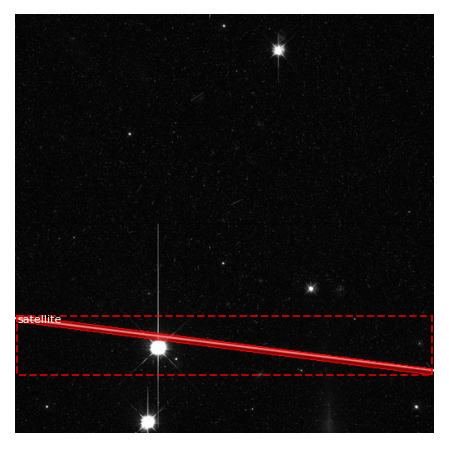

In [ ]:
#Test on a val image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


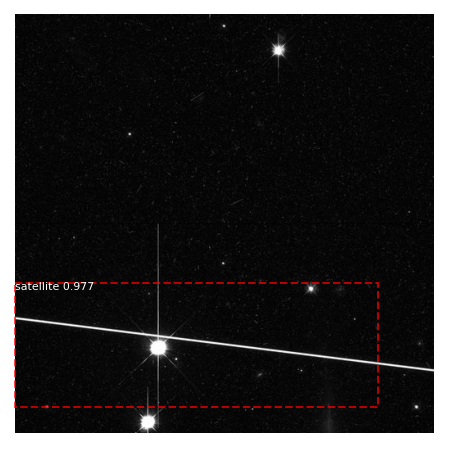

In [ ]:
#Display the results
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## All validation images

In [ ]:
#Compute VOC-Style mAP @ IoU=0.5
#Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    #Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    #Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    #Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

ValueError: ignored